# model building and evaluation

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV

import pandas as pd # a brilliant package for data manipulation & analysis, this package introduces a "dataframe" similar to that in R.
import os # default package that is included with python, helpful for filepath stuff. 
import numpy as np # a foundational package for  arrays, matricies, and associated mathmatical operations
import matplotlib.pyplot as plt # a foundational plotting and datavisualization library, highly customizable, but a bit less user friendly
import seaborn as sns # a newer plotting library, less customizable, but has better default settings & is much easier to plug and play

### defining some useful functions for model visualization and evaluation

In [47]:
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Recievor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

In [48]:
def ez_prc(model, x, y, pos_label=1):
    """prints a basic Precision-Recall curve. 
    recall: the porportion of positives in the dataset that were correctly classified. (true_pos/ (true_pos + false_neg))
    precision: the porportion of predicted y=1 values that are correct (true_pos/ (true_pos + false_pos))

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import average_precision_score, precision_recall_curve

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]

    precision, recall, thresholds =precision_recall_curve(y, y_proba, pos_label=1, sample_weight=None)
    avg_p=average_precision_score(y, y_proba, pos_label=1, sample_weight=None)
    
    plt.title('Precision-Recall curve')
    ax1= plt.plot(precision, recall, 'b', label = '%s AP = %0.3f' % (model_name, avg_p), linewidth=2)
    plt.legend(loc = 'lower left')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')

In [49]:
def evaluate_model(model, x,y, cv=True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score

    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc', cv=10)
        print("across 10 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc', cv=10)) 

    print("###metrics on provided dataset:###")
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,1] #predicted probabilities
    errors = abs(y_hat - y)
    mape = 100 * np.mean(errors / y) # mean absolute percentage error
    accuracy = 100 - mape 
    auc=roc_auc_score(y, y_proba)
    loss= log_loss(y, y_hat)

    print ('the AUC is: {:0.3f}'.format(auc))
    print ('the logloss is: {:0.3f}'.format(loss))
    print("confusion matrix:\n ", confusion_matrix(y, y_hat))
    print("classification report:\n ", classification_report(y,y_hat, digits=3))

    ez_roc(model, x, y, pos_label=1) #plotting roc curve
    plt.show()
    ez_prc(model, x, y, pos_label=1) #plotting roc curve
    plt.show()

### Importing data & final formatting train/test matricies for modeling

In [50]:
## importing datasets
x = pd.read_csv('../data/x.csv') ## assumes your working directory is the base of this github repo.
y = pd.read_csv('../data/y.csv') ## assumes your working directory is the base of this github repo.
x_test = pd.read_csv('../data/x_test.csv') ## assumes your working directory is the base of this github repo.
y_test = pd.read_csv('../data/y_test.csv') ## assumes your working directory is the base of this github repo.
train_recordid = pd.read_csv('../data/train_recordid.csv')
test_recordid = pd.read_csv('../data/test_recordid.csv')

In [51]:
#final formatting
y= np.ravel(np.array(y))
x= np.array(x)

y_test= np.ravel(np.array(y_test))
x_test= np.array(x_test)

In [52]:
x.shape

(794, 81)

# modeling

In [53]:
# this line of code ignores a benign RuntimeWarning that can occur in some circumstances
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

### Logistic Regression (Ridge regression): 

across 10 fold cv on trainingset, the model had 
 mean auroc: 0.821 
 std auroc: 0.028
###metrics on provided dataset:###
the AUC is: 0.890
the logloss is: 6.047
confusion matrix:
  [[323  74]
 [ 65 332]]
classification report:
                precision    recall  f1-score   support

         0.0      0.832     0.814     0.823       397
         1.0      0.818     0.836     0.827       397

    accuracy                          0.825       794
   macro avg      0.825     0.825     0.825       794
weighted avg      0.825     0.825     0.825       794



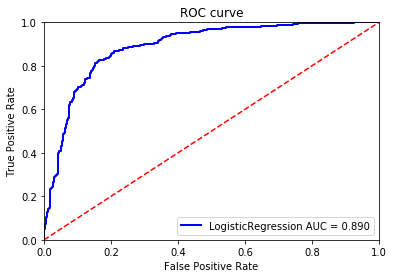

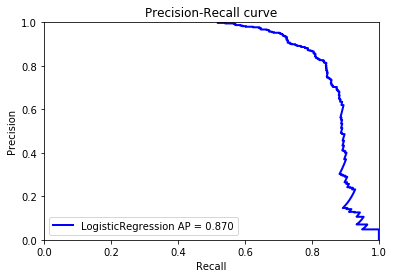

In [54]:
#define model
lr= LogisticRegression(penalty='l2',solver='liblinear', random_state = 12345)
#fit model
lr.fit(x,y)
#evaluate model (on training data)
evaluate_model(lr,x,y,cv=True)

### RandomForests:
1. hypertune parameters on cross validation
1. apply to train set

In [56]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring='auc_roc', verbose=False): 
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    from sklearn.model_selection import KFold, GridSearchCV
    np.random.seed(12345)

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=KFold(nfolds),
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)

        
    grid_search.fit(X, y)    
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
   
    return(grid_search)

In [57]:
### tuning RF hyperparameters
# Number of trees in random forest
n_estimators = [ 100, 300]
# Number of features to consider at every split
max_features = [3,10,'auto']
# Maximum number of levels in tree
max_depth = [5,25]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

model= RandomForestClassifier(criterion='entropy', random_state=12345)

rf_hyper=hypertuning_fxn(x, y, nfolds=5, model=model , param_grid=param_grid, scoring='roc_auc')

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.836
best cv params:  {'max_depth': 25, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
worst cv score: 0.811
worst cv params:  {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [58]:
rf_hyper.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

###metrics on provided dataset:###
the AUC is: 1.000
the logloss is: 0.000
confusion matrix:
  [[397   0]
 [  0 397]]
classification report:
                precision    recall  f1-score   support

         0.0      1.000     1.000     1.000       397
         1.0      1.000     1.000     1.000       397

    accuracy                          1.000       794
   macro avg      1.000     1.000     1.000       794
weighted avg      1.000     1.000     1.000       794



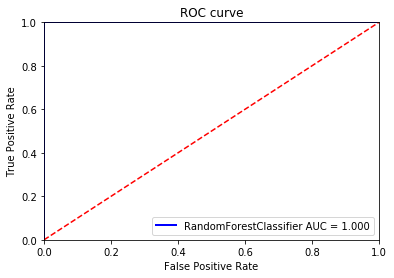

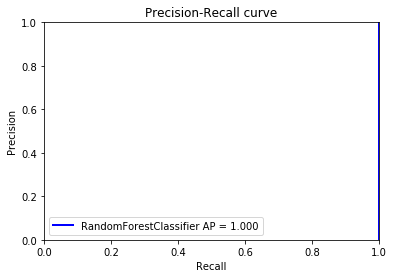

In [44]:
evaluate_model(rf_hyper.best_estimator_,x,y, cv=False)

## evaluate models (test data)


 LogisticRegression:
###metrics on provided dataset:###
the AUC is: 0.842
the logloss is: 12.051
confusion matrix:
  [[631 397]
 [ 21 149]]
classification report:
                precision    recall  f1-score   support

         0.0      0.968     0.614     0.751      1028
         1.0      0.273     0.876     0.416       170

    accuracy                          0.651      1198
   macro avg      0.620     0.745     0.584      1198
weighted avg      0.869     0.651     0.704      1198



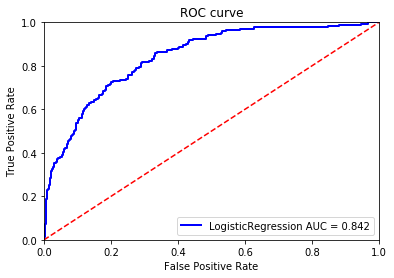

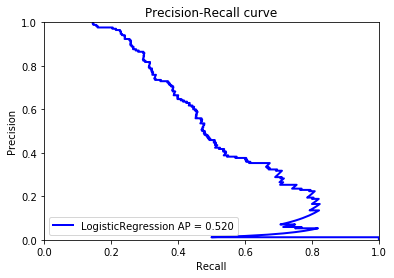


 RandomForests:
###metrics on provided dataset:###
the AUC is: 0.838
the logloss is: 12.253
confusion matrix:
  [[626 402]
 [ 23 147]]
classification report:
                precision    recall  f1-score   support

         0.0      0.965     0.609     0.747      1028
         1.0      0.268     0.865     0.409       170

    accuracy                          0.645      1198
   macro avg      0.616     0.737     0.578      1198
weighted avg      0.866     0.645     0.699      1198



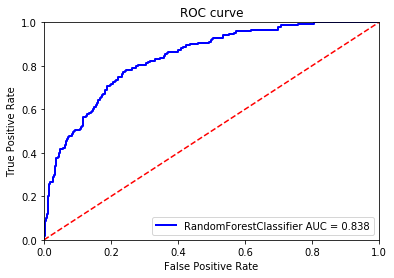

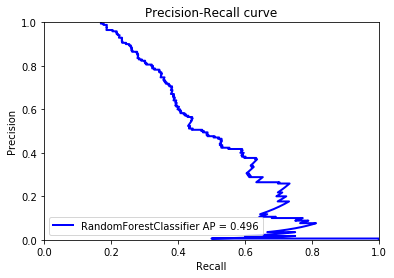

In [45]:
print('\n LogisticRegression:')
evaluate_model(lr,x_test,y_test, cv=False)
print('\n RandomForests:')
evaluate_model(rf_hyper.best_estimator_,x_test,y_test,cv=False)

In [33]:
x_test.shape

(1198, 81)

In [34]:
x.shape

(794, 81)